In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
nfft = 1024

In [3]:
def process(basename, antenna=0, dec=100000, fs=10.24, f_lo=2216.5, spacecraft='Orion', fsel=slice(350, 680),
            adjust_fsel=False, start_time=None, beamform=False):
    chanx, chany = ['x', 'y'] if not beamform else ['0', '1']
    if beamform:
        antenna = ''
    x = np.fromfile(f'/home/destevez/Artemis1/{basename}_fft1024_dec{dec}_{antenna}{chanx}{antenna}{chanx}.f32',
                'float32').reshape(-1, nfft)
    y = np.fromfile(f'/home/destevez/Artemis1/{basename}_fft1024_dec{dec}_{antenna}{chany}{antenna}{chany}.f32',
                'float32').reshape(-1, nfft)
    xy = np.fromfile(f'/home/destevez/Artemis1/{basename}_fft1024_dec{dec}_{antenna}{chanx}{antenna}{chany}.c64',
                 'complex64').reshape(-1, nfft)
    chanx, chany = ['X', 'Y'] if not beamform else ['1a', '5c']
    
    if adjust_fsel:
        plt.plot(np.average(x, axis=0))
        plt.plot(np.arange(nfft)[fsel], np.average(x, axis=0)[fsel])
    
    noise_sel = slice(900, 960)
    a = np.average(x[:, noise_sel])
    b = np.average(y[:, noise_sel])
    x /= a
    y /= b
    xy /= np.sqrt(a * b)
    
    print('Power ratio:', a/b)
    
    date_format = mdates.DateFormatter('%H:%M')
    
    faxis = np.fft.fftshift(np.fft.fftfreq(nfft, 1/fs)) + f_lo
    plt.figure()
    plt.plot(faxis, np.average(x, axis=0), label=f'|{chanx}|^2')
    plt.plot(faxis, np.average(y, axis=0), label=f'|{chany}|^2')
    plt.plot(faxis, np.average(np.abs(xy), axis=0), label=f'|{chanx}·{chany}|')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'Artemis I {spacecraft} PSD ({"linear polarizations" if not beamform else "two antennas"})')
    plt.ylabel('PSD (linear)')
    plt.legend()
    
    faxis = np.fft.fftshift(np.fft.fftfreq(nfft, 1/fs)) + f_lo
    plt.figure()
    plt.plot(faxis, 10*np.log10(np.average(x, axis=0)), label=f'|{chanx}|^2')
    plt.plot(faxis, 10*np.log10(np.average(y, axis=0)), label=f'|{chany}|^2')
    plt.plot(faxis, 10*np.log10(np.average(np.abs(xy), axis=0)), label=f'|{chanx}·{chany}|')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'Artemis I {spacecraft} PSD ({"linear polarizations" if not beamform else "two antennas"})')
    plt.ylabel('PSD (dB)')
    plt.legend()

    plt.figure()
    plt.plot(faxis[fsel], np.rad2deg(np.angle(np.average(xy[:, fsel], axis=0))))
    plt.title(f'Artemis I {spacecraft} phase({chanx}) - phase({chany}) versus frequency')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Phase difference (deg)')
    
    tstep = (nfft * dec)/(fs*1e6)
    taxis = tstep * np.arange(x.shape[0])
    if start_time is not None:
        taxis = start_time + (taxis * 1e9) * np.timedelta64(1, 'ns')
    
    xcorr = np.average(xy[:, fsel], axis=1)
    plt.figure()
    plt.title(f'Artemis I {spacecraft} phase({chanx}) - phase({chany}) versus time')
    plt.xlabel('Time (s)' if start_time is None
               else f'UTC time ({str(start_time).split("T")[0]})')
    plt.ylabel('Phase difference (deg)')
    plt.plot(taxis, np.rad2deg(np.angle(xcorr)))
    if start_time is not None:
        plt.gca().xaxis.set_major_formatter(date_format)
    
    theta = np.angle(np.average(xcorr))
    print('Phase difference:', np.rad2deg(theta))
    
    z = (x + y + 2*(np.exp(-1j * theta)*xy).real)/2
    zbar = (x + y - 2*(np.exp(-1j * theta)*xy).real)/2
    pwr = (np.sum(z[:, fsel], axis=1) - (fsel.stop - fsel.start + 1)) * (fs * 1e6 / nfft)
    
    plt.figure()
    plt.plot(faxis, np.average(z, axis=0), label='Signal polarization' if not beamform else 'Beamforming')
    plt.plot(faxis, np.average(zbar, axis=0), label='Orthogonal polarization' if not beamform else 'Nullforming')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'Artemis I {spacecraft} PSD ({"signal polarization" if not beamform else "beamforming"})')
    plt.ylabel('PSD (linear)')
    plt.legend()
    
    plt.figure()
    plt.plot(faxis, 10*np.log10(np.average(z, axis=0)), label='Signal polarization' if not beamform else 'Beamforming')
    plt.plot(faxis, 10*np.log10(np.average(zbar, axis=0)), label='Orthogonal polarization' if not beamform else 'Nullforming')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'Artemis I {spacecraft} PSD ({"signal polarization" if not beamform else "beamforming"})')
    plt.ylabel('PSD (dB)')
    plt.legend()
    
    fig, axs = plt.subplots(2, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    a = mdates.date2num(start_time) if start_time is not None else 0
    b = (
        mdates.date2num(start_time + (tstep * x.shape[0] * 1e9) * np.timedelta64(1, 'ns'))
        if start_time is not None
        else tstep * x.shape[0])
    axs[0].imshow(10 * np.log10(z).T[::-1], aspect='auto', vmin=-5, vmax=15,
                  extent=[a, b, f_lo - fs, f_lo + fs])
    axs[1].plot(taxis, 10 * np.log10(pwr))
    axs[0].set_ylabel('Frequency (MHz)')
    axs[1].set_ylabel('CN0 (dB·Hz)')
    plt.xlabel('Time (s)' if start_time is None
               else f'UTC time ({str(start_time).split("T")[0]})')
    if start_time is not None:
        axs[1].xaxis.set_major_formatter(date_format)
    plt.subplots_adjust(hspace=0.1)
    plt.suptitle(f'Artemis I {spacecraft} waterfall ({"signal polarization" if not beamform else "beamforming"})',
                 y=0.92)

Power ratio: 0.44921625
Phase difference: -14.329943


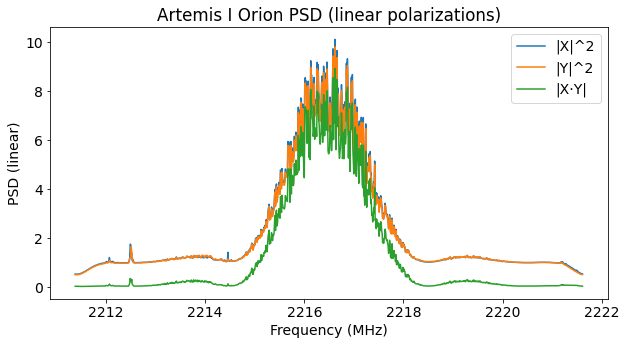

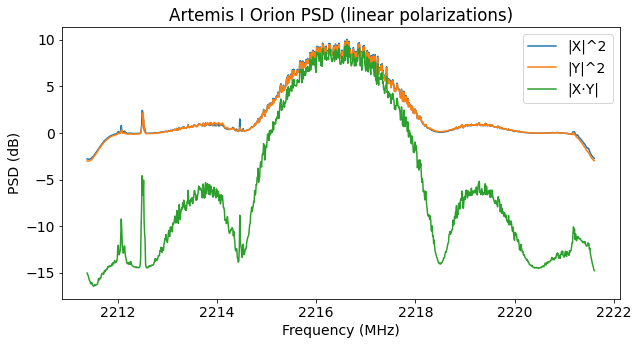

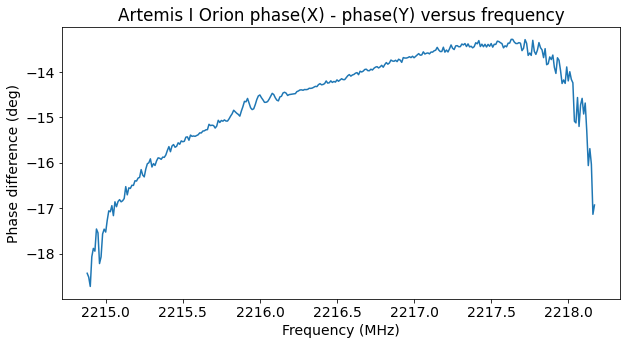

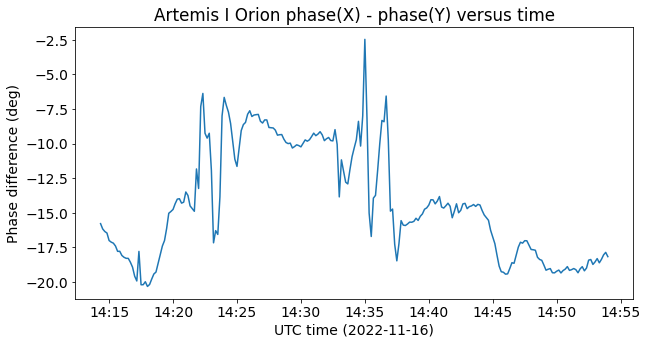

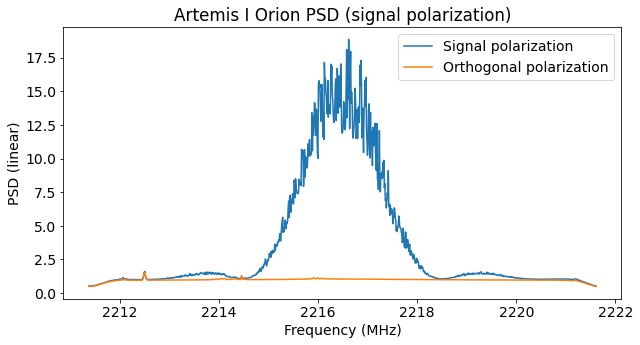

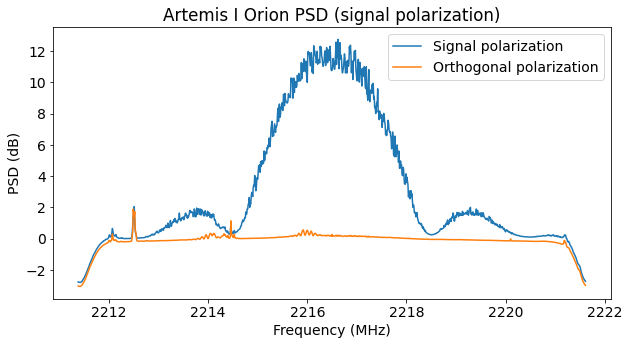

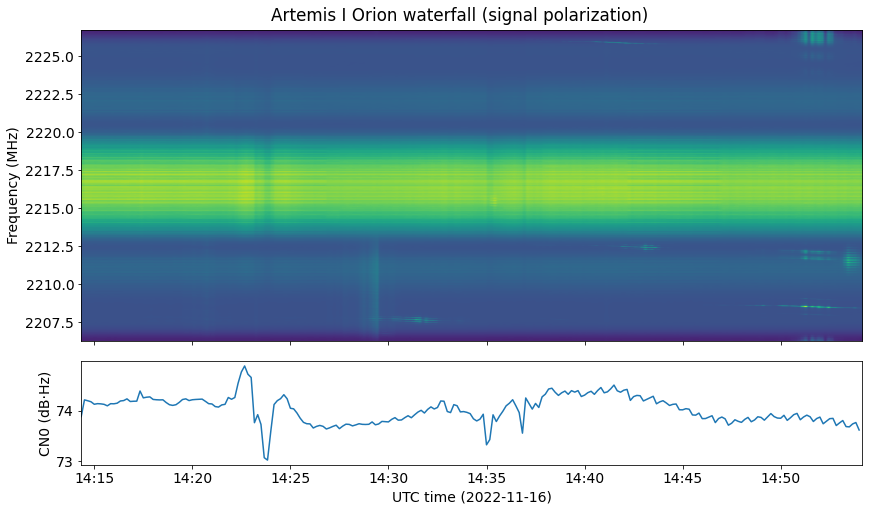

In [4]:
process('Orion_2022-11-16T14:14:09.425062', start_time=np.datetime64('2022-11-16T14:14:20'))

Power ratio: 0.45962524
Phase difference: -17.327684


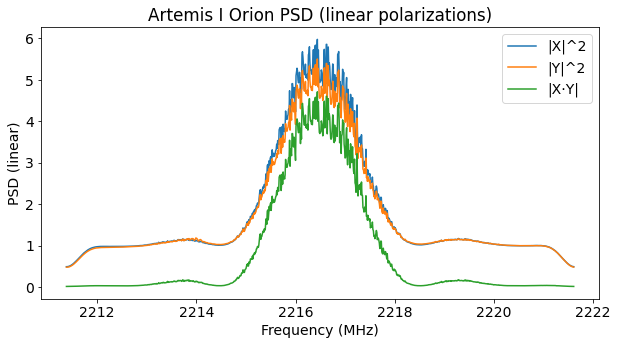

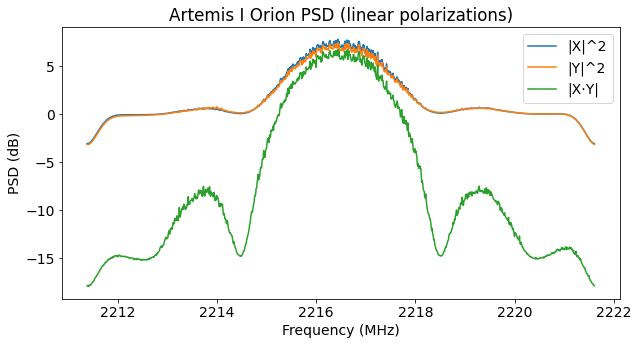

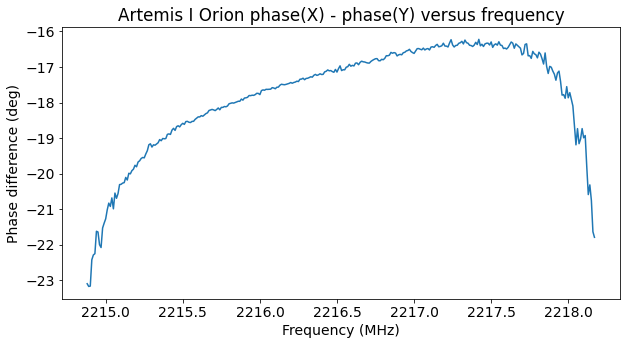

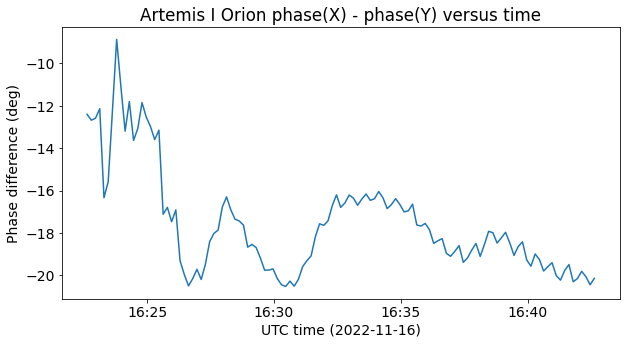

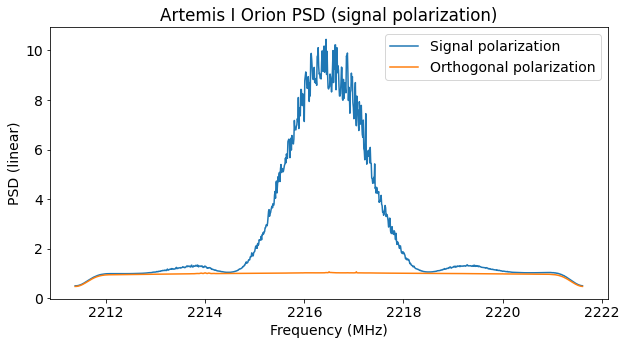

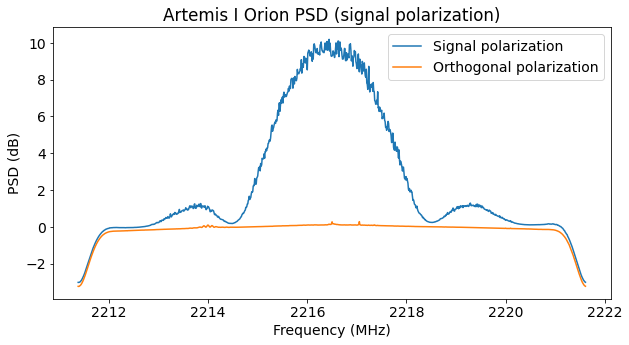

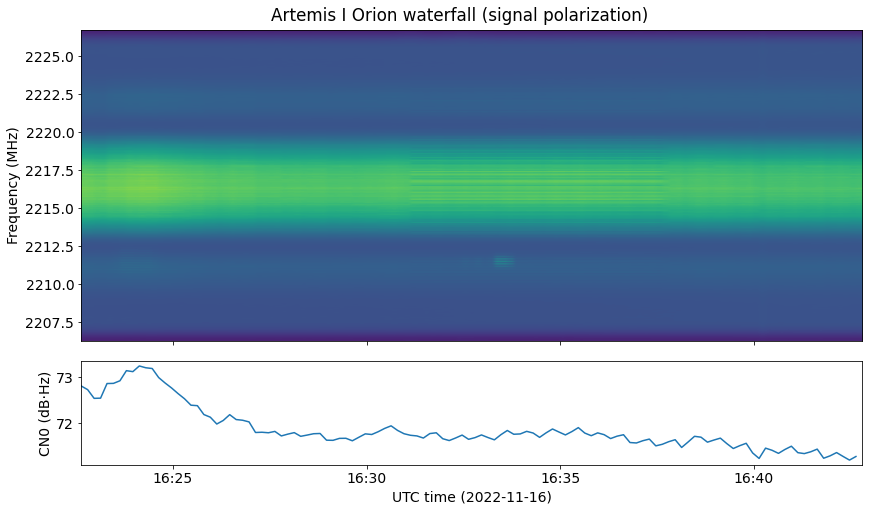

In [5]:
process('Orion_2022-11-16T16:22:25.503183', start_time=np.datetime64('2022-11-16T16:22:38'))

Power ratio: 0.49611613
Phase difference: -100.74782


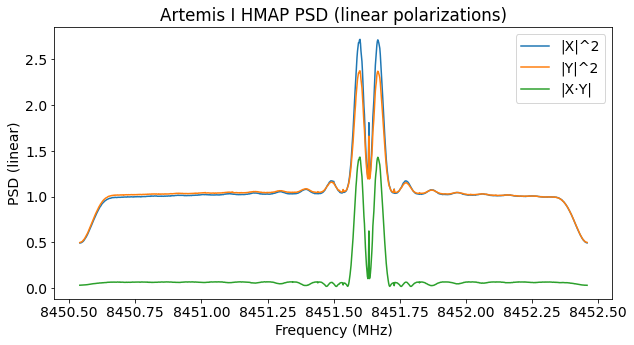

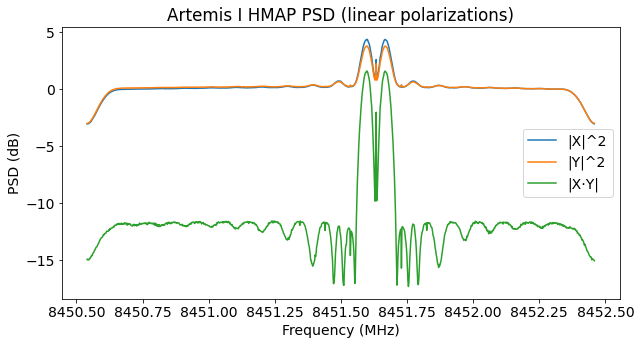

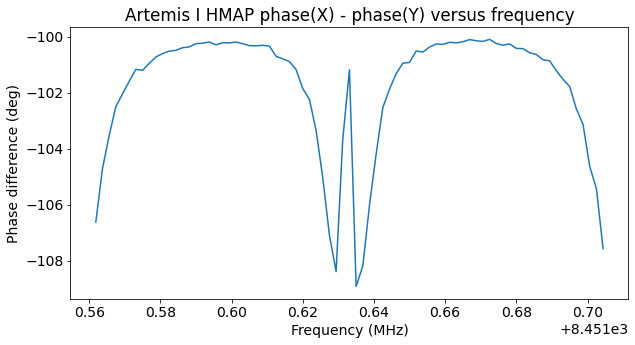

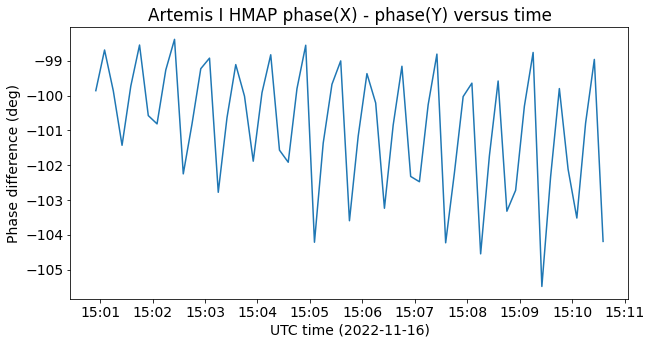

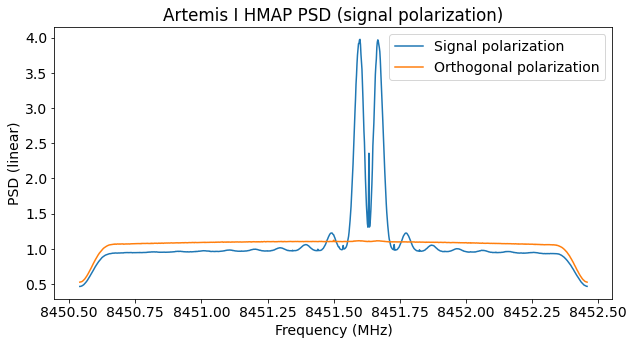

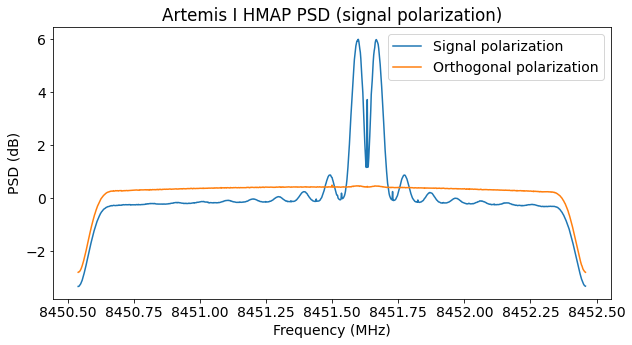

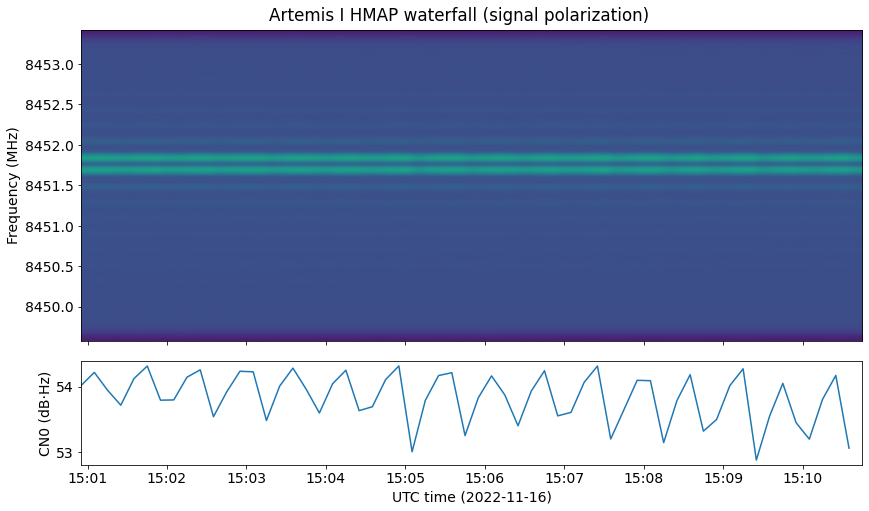

In [11]:
process('HMAP_2022-11-16T15:00:44.165313', spacecraft='HMAP',
        dec=18750, f_lo=8451.5, fs=1.92, fsel=slice(545, 622),
        start_time=np.datetime64('2022-11-16T15:00:55.139'))

Power ratio: 0.49614057
Phase difference: -107.121765


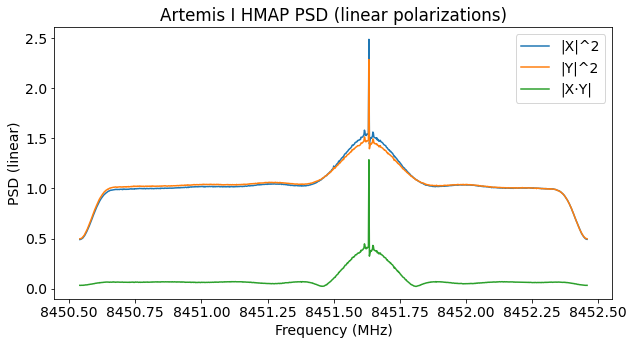

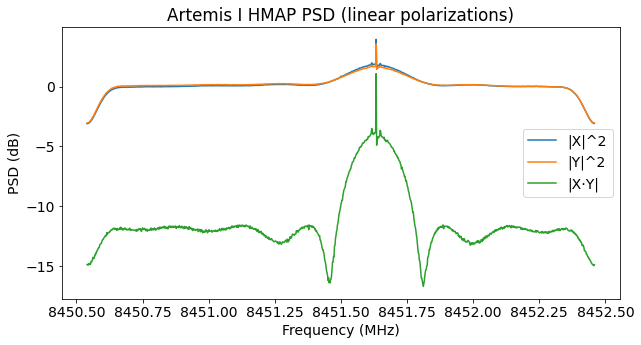

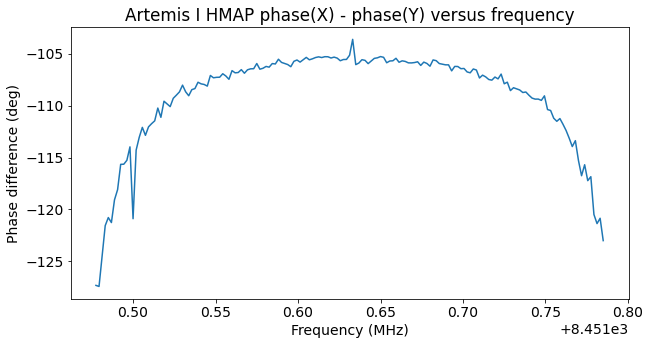

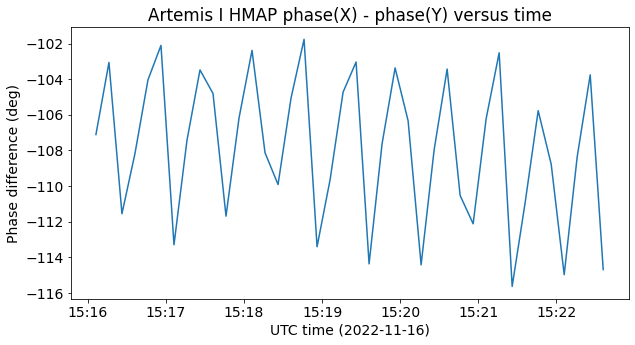

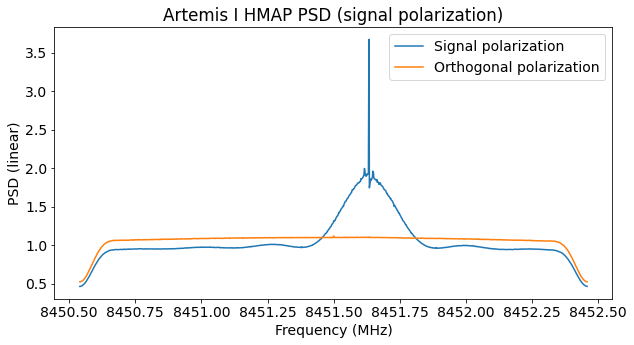

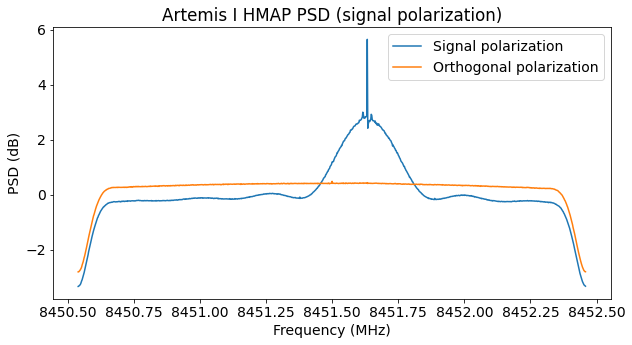

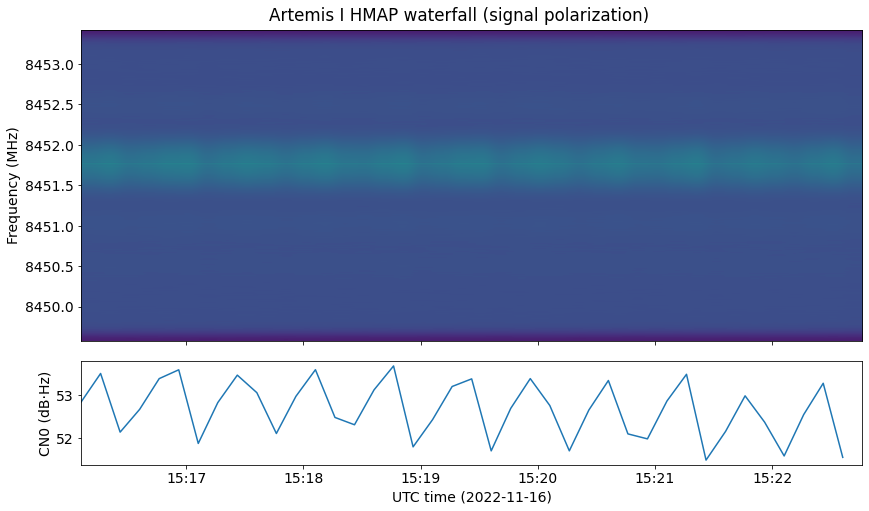

In [7]:
process('HMAP_2022-11-16T15:15:55.277147', spacecraft='HMAP',
        dec=18750, f_lo=8451.5, fs=1.92, fsel=slice(500, 665),
        start_time=np.datetime64('2022-11-16T15:16:06.142'))

Power ratio: 0.1771783
Phase difference: 52.029842


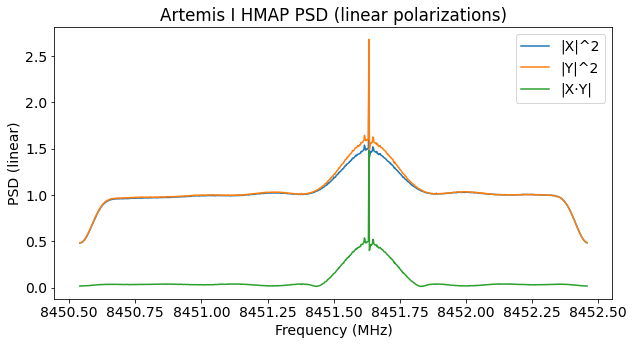

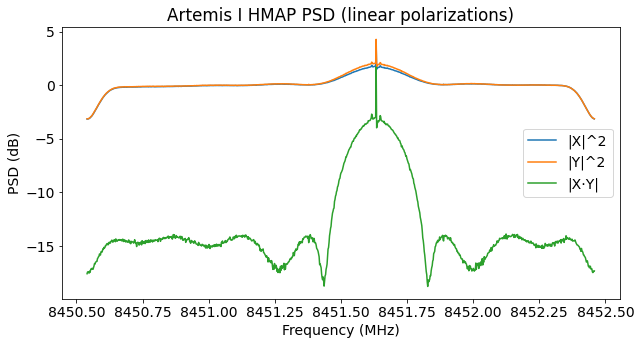

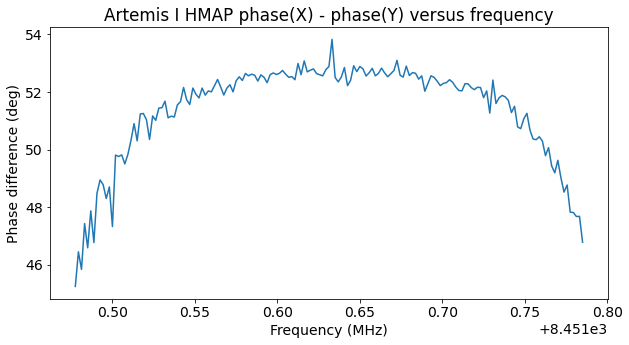

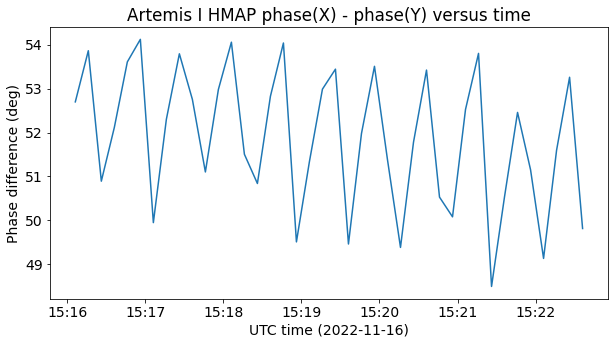

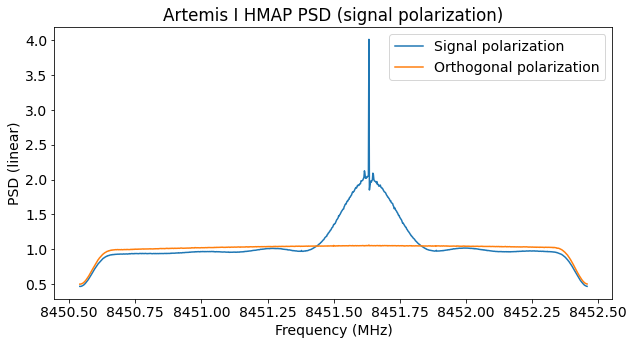

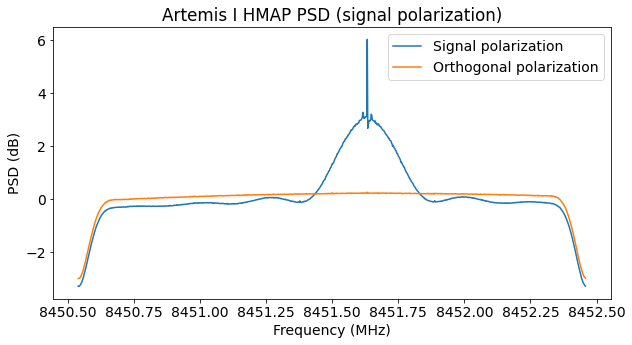

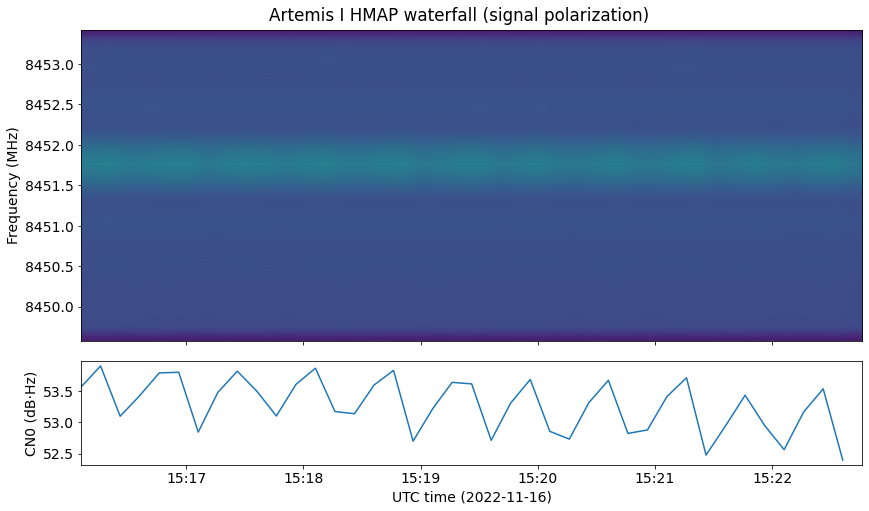

In [8]:
process('HMAP_2022-11-16T15:15:55.277147', spacecraft='HMAP',
        dec=18750, f_lo=8451.5, fs=1.92, fsel=slice(500, 665), antenna=1,
        start_time=np.datetime64('2022-11-16T15:16:06.142'))

Power ratio: 1.0778564
Phase difference: 0.09559492


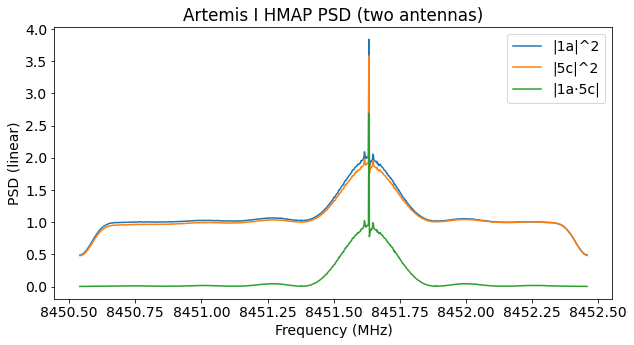

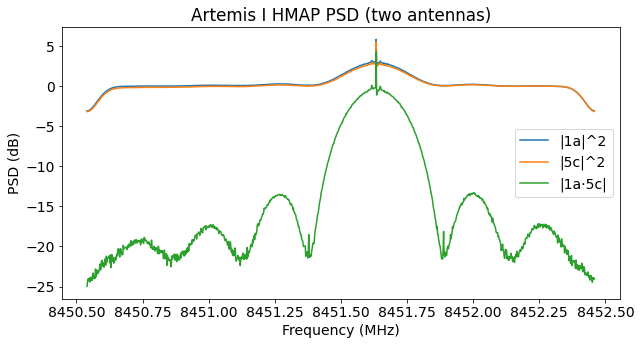

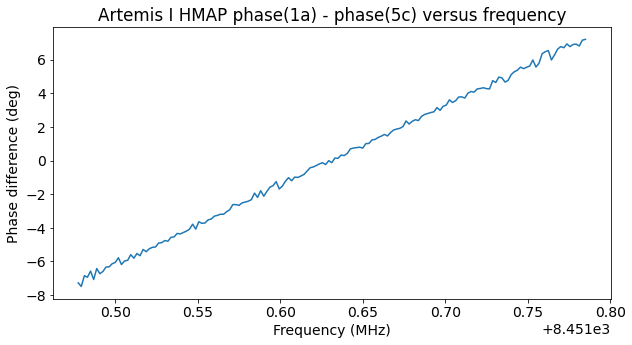

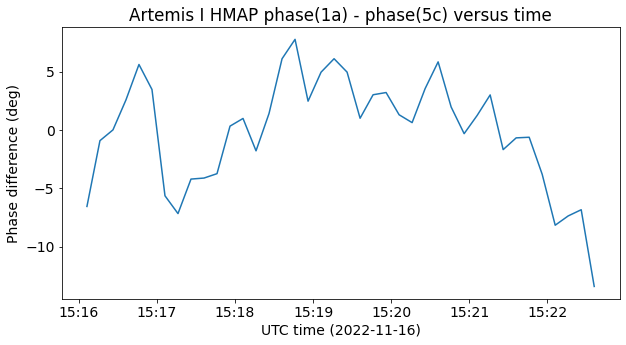

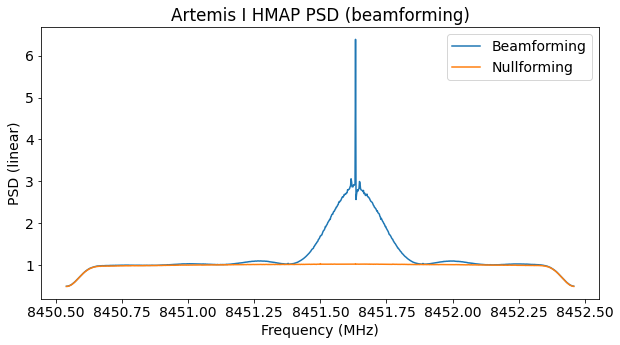

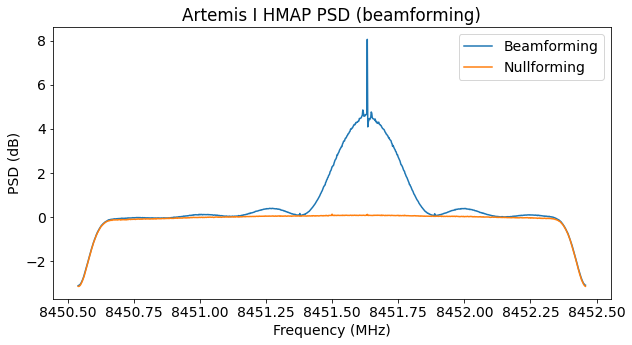

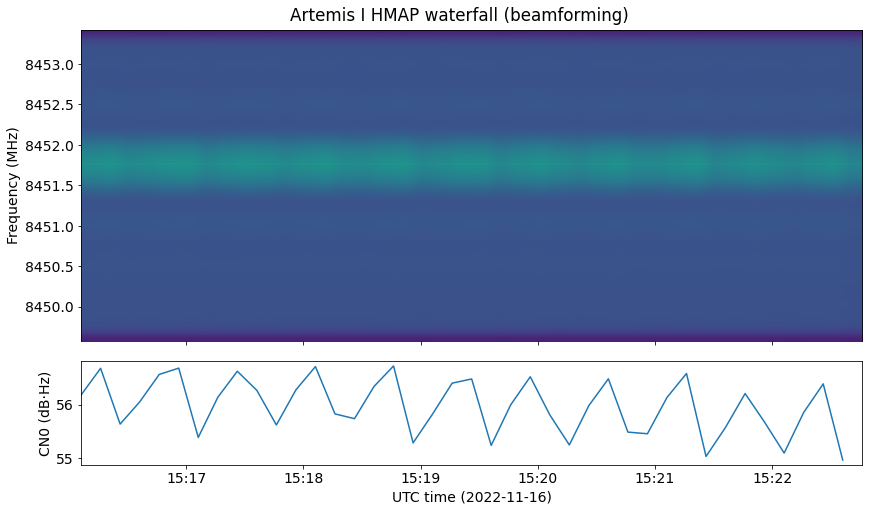

In [9]:
process('HMAP_2022-11-16T15:15:55.277147', spacecraft='HMAP',
        dec=18750, f_lo=8451.5, fs=1.92, fsel=slice(500, 665), beamform=True,
        start_time=np.datetime64('2022-11-16T15:16:06.142'))